In [152]:
# Imports
import evaluate
import torch
import wandb
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

from transformers import AutoModelForImageClassification, AutoImageProcessor, TrainingArguments, Trainer, DefaultDataCollator, pipeline
from datasets import load_dataset
from pathlib import Path

from hf_models.models.spice_cnn.image_processing_spice_cnn import SpiceCNNImageProcessor

HOME_DIRECTORY = Path.home()
MODEL_DIRECTORY = "spice-cnn-base"
MODEL_CACHE_DIRECTORY = Path(HOME_DIRECTORY / ".cache" / "hf-models" / MODEL_DIRECTORY)
MODEL_CACHE_DIRECTORY.mkdir(parents=True, exist_ok=True)

Found cached dataset mnist (/Users/ankush/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)


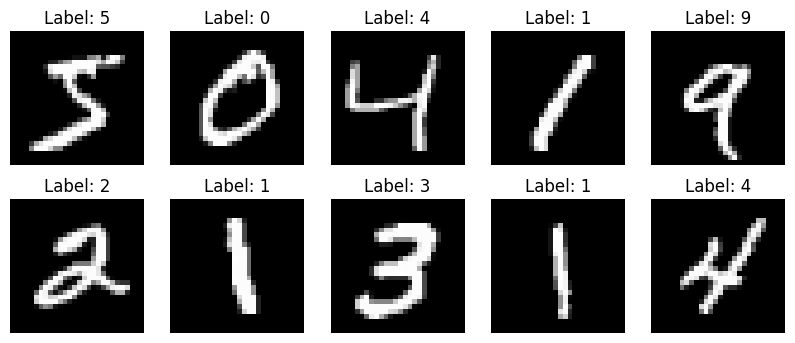

In [153]:
# Visualize the images
mnist_train = load_dataset("mnist", split="train")

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))

for i, ax in enumerate(axes.flatten()):
    image = mnist_train[i]["image"]
    label = mnist_train[i]["label"]
    image_array = np.array(image, dtype=np.float32)
    ax.imshow(image_array.squeeze(), cmap="gray")  # Squeeze the array if necessary
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.show()

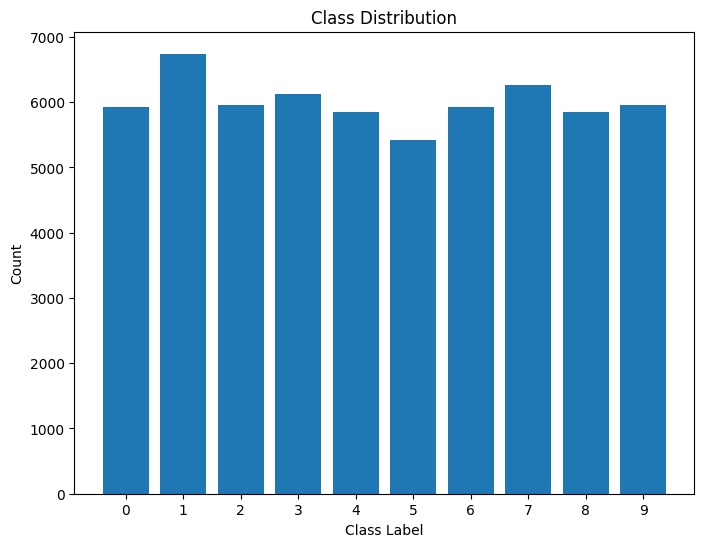

In [154]:
# Analyze the dataset
labels = mnist_train["label"]

# Calculate the class distribution
class_counts = np.bincount(labels)
class_labels = np.arange(10)

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_counts)
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(class_labels)
plt.show()

In [155]:
# Load mnist dataset
mnist = load_dataset("mnist")
labels = mnist["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

Found cached dataset mnist (/Users/ankush/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)


  0%|          | 0/2 [00:00<?, ?it/s]

In [156]:
# Preprocess mnist dataset
image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="spicecloud/spice-cnn-base",
    do_resize=False,
    do_rescale=False,
    do_normalize=False,
    trust_remote_code=True,
    size={"height": 28, "width": 28},
    image_mean = 0.5,
    image_std = 0.5,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

def transforms(examples):
    examples["tensor"] = [_transforms(img) for img in examples["image"]]
    del examples["image"]
    return examples

mnist = mnist.with_transform(transforms)
data_collator = DefaultDataCollator()

A new version of the following files was downloaded from https://huggingface.co/spicecloud/spice-cnn-base:
- image_processing_spice_cnn.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [157]:
from torchsummary import summary
model = AutoModelForImageClassification.from_pretrained(
    pretrained_model_name_or_path="spicecloud/spice-cnn-base",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    trust_remote_code=True,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.model = model.model.to(device)

summary(model.model, input_size=(1,28,28))

A new version of the following files was downloaded from https://huggingface.co/spicecloud/spice-cnn-base:
- configuration_spice_cnn.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


A new version of the following files was downloaded from https://huggingface.co/spicecloud/spice-cnn-base:
- modeling_spice_cnn.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
         MaxPool2d-4           [-1, 16, 14, 14]               0
            Conv2d-5           [-1, 32, 14, 14]           4,640
       BatchNorm2d-6           [-1, 32, 14, 14]              64
              ReLU-7           [-1, 32, 14, 14]               0
         MaxPool2d-8             [-1, 32, 7, 7]               0
            Conv2d-9             [-1, 64, 7, 7]          18,496
      BatchNorm2d-10             [-1, 64, 7, 7]             128
             ReLU-11             [-1, 64, 7, 7]               0
        MaxPool2d-12             [-1, 64, 3, 3]               0
          Flatten-13                  [-1, 576]               0
           Linear-14                  [

In [158]:
# Evaluate
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [159]:
# Train
model = AutoModelForImageClassification.from_pretrained(
    pretrained_model_name_or_path="spicecloud/spice-cnn-base",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    trust_remote_code=True,
)

training_args = TrainingArguments(
    output_dir=MODEL_CACHE_DIRECTORY,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-3,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4, # number of update steps to accumulate the gradient for before a backward pass
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    warmup_ratio=0.1, # ratio of total training steps used for a linear warmup from 0 to 'learning_rate'
    logging_steps=10, # number of update steps between two logs
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    report_to="wandb",
    use_mps_device=torch.backends.mps.is_available(),
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=mnist["train"],
    eval_dataset=mnist["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

wandb.finish()

/Users/ankush/Library/Caches/pypoetry/virtualenvs/hf-models-JChwTGhx-py3.11/lib/python3.11/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/9360 [00:00<?, ?it/s]

Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'loss': 2.3692, 'learning_rate': 1.0683760683760684e-05, 'epoch': 0.02}
{'loss': 2.3591, 'learning_rate': 2.1367521367521368e-05, 'epoch': 0.04}
{'loss': 2.338, 'learning_rate': 3.205128205128205e-05, 'epoch': 0.06}
{'loss': 2.3217, 'learning_rate': 4.2735042735042735e-05, 'epoch': 0.09}
{'loss': 2.2933, 'learning_rate': 5.341880341880342e-05, 'epoch': 0.11}
{'loss': 2.2712, 'learning_rate': 6.41025641025641e-05, 'epoch': 0.13}
{'loss': 2.25, 'learning_rate': 7.478632478632479e-05, 'epoch': 0.15}
{'loss': 2.2266, 'learning_rate': 8.547008547008547e-05, 'epoch': 0.17}
{'loss': 2.1954, 'learning_rate': 9.615384615384617e-05, 'epoch': 0.19}
{'loss': 2.1574, 'learning_rate': 0.00010683760683760684, 'epoch': 0.21}
{'loss': 2.121, 'learning_rate': 0.00011752136752136752, 'epoch': 0.23}
{'loss': 2.081, 'learning_rate': 0.0001282051282051282, 'epoch': 0.26}
{'loss': 2.0288, 'learning_rate': 0.0001388888888888889, 'epoch': 0.28}
{'loss': 2.0094, 'learning_rate': 0.00014957264957264957, 'epoch'

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.8801648616790771, 'eval_accuracy': 0.7203, 'eval_runtime': 2.1142, 'eval_samples_per_second': 4729.881, 'eval_steps_per_second': 148.045, 'epoch': 1.0}
{'loss': 1.0137, 'learning_rate': 0.0005021367521367521, 'epoch': 1.0}
{'loss': 1.0188, 'learning_rate': 0.0005128205128205128, 'epoch': 1.02}
{'loss': 1.0037, 'learning_rate': 0.0005235042735042735, 'epoch': 1.05}
{'loss': 0.983, 'learning_rate': 0.0005341880341880342, 'epoch': 1.07}
{'loss': 0.9642, 'learning_rate': 0.0005448717948717948, 'epoch': 1.09}
{'loss': 0.9679, 'learning_rate': 0.0005555555555555556, 'epoch': 1.11}
{'loss': 0.9288, 'learning_rate': 0.0005662393162393163, 'epoch': 1.13}
{'loss': 0.9133, 'learning_rate': 0.0005769230769230769, 'epoch': 1.15}
{'loss': 0.886, 'learning_rate': 0.0005876068376068377, 'epoch': 1.17}
{'loss': 0.943, 'learning_rate': 0.0005982905982905983, 'epoch': 1.19}
{'loss': 0.9325, 'learning_rate': 0.0006089743589743589, 'epoch': 1.22}
{'loss': 0.8644, 'learning_rate': 0.00061965

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.6204606294631958, 'eval_accuracy': 0.7939, 'eval_runtime': 1.9026, 'eval_samples_per_second': 5255.866, 'eval_steps_per_second': 164.509, 'epoch': 2.0}
{'loss': 0.7595, 'learning_rate': 0.0009995251661918329, 'epoch': 2.01}
{'loss': 0.6804, 'learning_rate': 0.000998338081671415, 'epoch': 2.03}
{'loss': 0.7332, 'learning_rate': 0.0009971509971509972, 'epoch': 2.05}
{'loss': 0.7063, 'learning_rate': 0.0009959639126305793, 'epoch': 2.07}
{'loss': 0.6908, 'learning_rate': 0.0009947768281101616, 'epoch': 2.09}
{'loss': 0.7756, 'learning_rate': 0.0009935897435897436, 'epoch': 2.11}
{'loss': 0.6815, 'learning_rate': 0.000992402659069326, 'epoch': 2.13}
{'loss': 0.7029, 'learning_rate': 0.000991215574548908, 'epoch': 2.15}
{'loss': 0.725, 'learning_rate': 0.00099002849002849, 'epoch': 2.18}
{'loss': 0.7316, 'learning_rate': 0.0009888414055080723, 'epoch': 2.2}
{'loss': 0.7576, 'learning_rate': 0.0009876543209876543, 'epoch': 2.22}
{'loss': 0.6842, 'learning_rate': 0.00098646723

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.5619778037071228, 'eval_accuracy': 0.81, 'eval_runtime': 1.8985, 'eval_samples_per_second': 5267.3, 'eval_steps_per_second': 164.866, 'epoch': 3.0}
{'loss': 0.6588, 'learning_rate': 0.0009437321937321938, 'epoch': 3.01}
{'loss': 0.5997, 'learning_rate': 0.0009425451092117759, 'epoch': 3.03}
{'loss': 0.6835, 'learning_rate': 0.000941358024691358, 'epoch': 3.05}
{'loss': 0.5949, 'learning_rate': 0.0009401709401709402, 'epoch': 3.07}
{'loss': 0.6077, 'learning_rate': 0.0009389838556505223, 'epoch': 3.09}
{'loss': 0.5682, 'learning_rate': 0.0009377967711301045, 'epoch': 3.11}
{'loss': 0.5901, 'learning_rate': 0.0009366096866096866, 'epoch': 3.14}
{'loss': 0.6295, 'learning_rate': 0.0009354226020892687, 'epoch': 3.16}
{'loss': 0.616, 'learning_rate': 0.0009342355175688509, 'epoch': 3.18}
{'loss': 0.6581, 'learning_rate': 0.0009330484330484332, 'epoch': 3.2}
{'loss': 0.6024, 'learning_rate': 0.0009318613485280152, 'epoch': 3.22}
{'loss': 0.6281, 'learning_rate': 0.00093067426

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.4888465702533722, 'eval_accuracy': 0.8345, 'eval_runtime': 1.9567, 'eval_samples_per_second': 5110.766, 'eval_steps_per_second': 159.967, 'epoch': 4.0}
{'loss': 0.5668, 'learning_rate': 0.0008879392212725547, 'epoch': 4.01}
{'loss': 0.5826, 'learning_rate': 0.0008867521367521367, 'epoch': 4.03}
{'loss': 0.5567, 'learning_rate': 0.0008855650522317189, 'epoch': 4.05}
{'loss': 0.5713, 'learning_rate': 0.0008843779677113011, 'epoch': 4.07}
{'loss': 0.6048, 'learning_rate': 0.0008831908831908832, 'epoch': 4.1}
{'loss': 0.5098, 'learning_rate': 0.0008820037986704653, 'epoch': 4.12}
{'loss': 0.5988, 'learning_rate': 0.0008808167141500475, 'epoch': 4.14}
{'loss': 0.5598, 'learning_rate': 0.0008796296296296296, 'epoch': 4.16}
{'loss': 0.5427, 'learning_rate': 0.0008784425451092119, 'epoch': 4.18}
{'loss': 0.5842, 'learning_rate': 0.000877255460588794, 'epoch': 4.2}
{'loss': 0.5232, 'learning_rate': 0.0008760683760683761, 'epoch': 4.22}
{'loss': 0.5739, 'learning_rate': 0.0008748

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.45549076795578003, 'eval_accuracy': 0.8441, 'eval_runtime': 1.9087, 'eval_samples_per_second': 5239.281, 'eval_steps_per_second': 163.99, 'epoch': 5.0}
{'loss': 0.5112, 'learning_rate': 0.0008321462488129154, 'epoch': 5.01}
{'loss': 0.55, 'learning_rate': 0.0008309591642924976, 'epoch': 5.03}
{'loss': 0.5679, 'learning_rate': 0.0008297720797720798, 'epoch': 5.06}
{'loss': 0.5205, 'learning_rate': 0.000828584995251662, 'epoch': 5.08}
{'loss': 0.5712, 'learning_rate': 0.000827397910731244, 'epoch': 5.1}
{'loss': 0.5545, 'learning_rate': 0.0008262108262108262, 'epoch': 5.12}
{'loss': 0.5224, 'learning_rate': 0.0008250237416904083, 'epoch': 5.14}
{'loss': 0.5764, 'learning_rate': 0.0008238366571699906, 'epoch': 5.16}
{'loss': 0.5677, 'learning_rate': 0.0008226495726495727, 'epoch': 5.18}
{'loss': 0.5765, 'learning_rate': 0.0008214624881291548, 'epoch': 5.21}
{'loss': 0.5371, 'learning_rate': 0.000820275403608737, 'epoch': 5.23}
{'loss': 0.4864, 'learning_rate': 0.0008190883

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.43664178252220154, 'eval_accuracy': 0.8514, 'eval_runtime': 1.8867, 'eval_samples_per_second': 5300.342, 'eval_steps_per_second': 165.901, 'epoch': 6.0}
{'loss': 0.5392, 'learning_rate': 0.0007763532763532763, 'epoch': 6.02}
{'loss': 0.5268, 'learning_rate': 0.0007751661918328585, 'epoch': 6.04}
{'loss': 0.5216, 'learning_rate': 0.0007739791073124407, 'epoch': 6.06}
{'loss': 0.5003, 'learning_rate': 0.0007727920227920227, 'epoch': 6.08}
{'loss': 0.5559, 'learning_rate': 0.0007716049382716049, 'epoch': 6.1}
{'loss': 0.4756, 'learning_rate': 0.0007704178537511871, 'epoch': 6.12}
{'loss': 0.5121, 'learning_rate': 0.0007692307692307693, 'epoch': 6.14}
{'loss': 0.5185, 'learning_rate': 0.0007680436847103514, 'epoch': 6.17}
{'loss': 0.5329, 'learning_rate': 0.0007668566001899336, 'epoch': 6.19}
{'loss': 0.4765, 'learning_rate': 0.0007656695156695157, 'epoch': 6.21}
{'loss': 0.5195, 'learning_rate': 0.0007644824311490979, 'epoch': 6.23}
{'loss': 0.5374, 'learning_rate': 0.0007

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.42337319254875183, 'eval_accuracy': 0.8578, 'eval_runtime': 1.8619, 'eval_samples_per_second': 5370.97, 'eval_steps_per_second': 168.111, 'epoch': 7.0}
{'loss': 0.5097, 'learning_rate': 0.0007205603038936372, 'epoch': 7.02}
{'loss': 0.4789, 'learning_rate': 0.0007193732193732194, 'epoch': 7.04}
{'loss': 0.5199, 'learning_rate': 0.0007181861348528014, 'epoch': 7.06}
{'loss': 0.5515, 'learning_rate': 0.0007169990503323836, 'epoch': 7.08}
{'loss': 0.5187, 'learning_rate': 0.0007158119658119658, 'epoch': 7.1}
{'loss': 0.4718, 'learning_rate': 0.0007146248812915481, 'epoch': 7.13}
{'loss': 0.5309, 'learning_rate': 0.0007134377967711301, 'epoch': 7.15}
{'loss': 0.4953, 'learning_rate': 0.0007122507122507123, 'epoch': 7.17}
{'loss': 0.4709, 'learning_rate': 0.0007110636277302945, 'epoch': 7.19}
{'loss': 0.4586, 'learning_rate': 0.0007098765432098766, 'epoch': 7.21}
{'loss': 0.4917, 'learning_rate': 0.0007086894586894587, 'epoch': 7.23}
{'loss': 0.5045, 'learning_rate': 0.00070

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.4258100688457489, 'eval_accuracy': 0.8526, 'eval_runtime': 1.8678, 'eval_samples_per_second': 5353.862, 'eval_steps_per_second': 167.576, 'epoch': 8.0}
{'loss': 0.4863, 'learning_rate': 0.0006647673314339981, 'epoch': 8.02}
{'loss': 0.4357, 'learning_rate': 0.0006635802469135802, 'epoch': 8.04}
{'loss': 0.4508, 'learning_rate': 0.0006623931623931623, 'epoch': 8.06}
{'loss': 0.4903, 'learning_rate': 0.0006612060778727446, 'epoch': 8.09}
{'loss': 0.4572, 'learning_rate': 0.0006600189933523268, 'epoch': 8.11}
{'loss': 0.4892, 'learning_rate': 0.0006588319088319088, 'epoch': 8.13}
{'loss': 0.4542, 'learning_rate': 0.000657644824311491, 'epoch': 8.15}
{'loss': 0.4361, 'learning_rate': 0.0006564577397910732, 'epoch': 8.17}
{'loss': 0.5257, 'learning_rate': 0.0006552706552706553, 'epoch': 8.19}
{'loss': 0.4646, 'learning_rate': 0.0006540835707502374, 'epoch': 8.21}
{'loss': 0.4723, 'learning_rate': 0.0006528964862298196, 'epoch': 8.23}
{'loss': 0.4782, 'learning_rate': 0.00065

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.39851030707359314, 'eval_accuracy': 0.8649, 'eval_runtime': 1.9007, 'eval_samples_per_second': 5261.158, 'eval_steps_per_second': 164.674, 'epoch': 9.0}
{'loss': 0.4658, 'learning_rate': 0.0006101614434947768, 'epoch': 9.0}
{'loss': 0.4644, 'learning_rate': 0.0006089743589743589, 'epoch': 9.02}
{'loss': 0.4704, 'learning_rate': 0.0006077872744539411, 'epoch': 9.05}
{'loss': 0.4601, 'learning_rate': 0.0006066001899335233, 'epoch': 9.07}
{'loss': 0.4398, 'learning_rate': 0.0006054131054131055, 'epoch': 9.09}
{'loss': 0.4974, 'learning_rate': 0.0006042260208926876, 'epoch': 9.11}
{'loss': 0.4838, 'learning_rate': 0.0006030389363722697, 'epoch': 9.13}
{'loss': 0.4602, 'learning_rate': 0.0006018518518518519, 'epoch': 9.15}
{'loss': 0.453, 'learning_rate': 0.0006006647673314341, 'epoch': 9.17}
{'loss': 0.4296, 'learning_rate': 0.0005994776828110161, 'epoch': 9.19}
{'loss': 0.4221, 'learning_rate': 0.0005982905982905983, 'epoch': 9.22}
{'loss': 0.4719, 'learning_rate': 0.00059

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.3846268057823181, 'eval_accuracy': 0.8694, 'eval_runtime': 1.8636, 'eval_samples_per_second': 5366.056, 'eval_steps_per_second': 167.958, 'epoch': 10.0}
{'loss': 0.4537, 'learning_rate': 0.0005543684710351377, 'epoch': 10.01}
{'loss': 0.4686, 'learning_rate': 0.0005531813865147198, 'epoch': 10.03}
{'loss': 0.3971, 'learning_rate': 0.0005519943019943021, 'epoch': 10.05}
{'loss': 0.4383, 'learning_rate': 0.0005508072174738842, 'epoch': 10.07}
{'loss': 0.4551, 'learning_rate': 0.0005496201329534663, 'epoch': 10.09}
{'loss': 0.4338, 'learning_rate': 0.0005484330484330485, 'epoch': 10.11}
{'loss': 0.432, 'learning_rate': 0.0005472459639126306, 'epoch': 10.13}
{'loss': 0.4378, 'learning_rate': 0.0005460588793922128, 'epoch': 10.15}
{'loss': 0.468, 'learning_rate': 0.0005448717948717948, 'epoch': 10.18}
{'loss': 0.4939, 'learning_rate': 0.000543684710351377, 'epoch': 10.2}
{'loss': 0.4567, 'learning_rate': 0.0005424976258309592, 'epoch': 10.22}
{'loss': 0.4492, 'learning_rate'

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.39035555720329285, 'eval_accuracy': 0.8678, 'eval_runtime': 1.8828, 'eval_samples_per_second': 5311.284, 'eval_steps_per_second': 166.243, 'epoch': 11.0}
{'loss': 0.4506, 'learning_rate': 0.0004985754985754986, 'epoch': 11.01}
{'loss': 0.485, 'learning_rate': 0.0004973884140550808, 'epoch': 11.03}
{'loss': 0.5139, 'learning_rate': 0.000496201329534663, 'epoch': 11.05}
{'loss': 0.4935, 'learning_rate': 0.000495014245014245, 'epoch': 11.07}
{'loss': 0.4953, 'learning_rate': 0.0004938271604938272, 'epoch': 11.09}
{'loss': 0.437, 'learning_rate': 0.0004926400759734093, 'epoch': 11.11}
{'loss': 0.4127, 'learning_rate': 0.0004914529914529914, 'epoch': 11.14}
{'loss': 0.452, 'learning_rate': 0.0004902659069325736, 'epoch': 11.16}
{'loss': 0.4724, 'learning_rate': 0.0004890788224121557, 'epoch': 11.18}
{'loss': 0.4343, 'learning_rate': 0.0004878917378917379, 'epoch': 11.2}
{'loss': 0.4699, 'learning_rate': 0.00048670465337132, 'epoch': 11.22}
{'loss': 0.4284, 'learning_rate': 0

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.3802845776081085, 'eval_accuracy': 0.8686, 'eval_runtime': 1.8738, 'eval_samples_per_second': 5336.682, 'eval_steps_per_second': 167.038, 'epoch': 12.0}
{'loss': 0.4491, 'learning_rate': 0.00044278252611585945, 'epoch': 12.01}
{'loss': 0.4733, 'learning_rate': 0.0004415954415954416, 'epoch': 12.03}
{'loss': 0.4392, 'learning_rate': 0.0004404083570750237, 'epoch': 12.05}
{'loss': 0.4098, 'learning_rate': 0.00043922127255460595, 'epoch': 12.07}
{'loss': 0.4813, 'learning_rate': 0.00043803418803418806, 'epoch': 12.1}
{'loss': 0.4176, 'learning_rate': 0.00043684710351377023, 'epoch': 12.12}
{'loss': 0.4127, 'learning_rate': 0.00043566001899335234, 'epoch': 12.14}
{'loss': 0.4584, 'learning_rate': 0.00043447293447293445, 'epoch': 12.16}
{'loss': 0.4494, 'learning_rate': 0.0004332858499525166, 'epoch': 12.18}
{'loss': 0.4327, 'learning_rate': 0.00043209876543209873, 'epoch': 12.2}
{'loss': 0.3924, 'learning_rate': 0.0004309116809116809, 'epoch': 12.22}
{'loss': 0.491, 'learni

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.37022367119789124, 'eval_accuracy': 0.8729, 'eval_runtime': 1.8545, 'eval_samples_per_second': 5392.351, 'eval_steps_per_second': 168.781, 'epoch': 13.0}
{'loss': 0.4485, 'learning_rate': 0.00038698955365622033, 'epoch': 13.01}
{'loss': 0.3945, 'learning_rate': 0.00038580246913580245, 'epoch': 13.03}
{'loss': 0.423, 'learning_rate': 0.00038461538461538467, 'epoch': 13.06}
{'loss': 0.4363, 'learning_rate': 0.0003834283000949668, 'epoch': 13.08}
{'loss': 0.4339, 'learning_rate': 0.00038224121557454895, 'epoch': 13.1}
{'loss': 0.4371, 'learning_rate': 0.00038105413105413106, 'epoch': 13.12}
{'loss': 0.455, 'learning_rate': 0.00037986704653371323, 'epoch': 13.14}
{'loss': 0.447, 'learning_rate': 0.00037867996201329534, 'epoch': 13.16}
{'loss': 0.4397, 'learning_rate': 0.00037749287749287746, 'epoch': 13.18}
{'loss': 0.4602, 'learning_rate': 0.0003763057929724596, 'epoch': 13.21}
{'loss': 0.4359, 'learning_rate': 0.0003751187084520418, 'epoch': 13.23}
{'loss': 0.4704, 'learn

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.36032968759536743, 'eval_accuracy': 0.8769, 'eval_runtime': 1.8871, 'eval_samples_per_second': 5299.205, 'eval_steps_per_second': 165.865, 'epoch': 14.0}
{'loss': 0.4477, 'learning_rate': 0.00033119658119658117, 'epoch': 14.02}
{'loss': 0.4267, 'learning_rate': 0.0003300094966761634, 'epoch': 14.04}
{'loss': 0.4403, 'learning_rate': 0.0003288224121557455, 'epoch': 14.06}
{'loss': 0.4051, 'learning_rate': 0.00032763532763532767, 'epoch': 14.08}
{'loss': 0.4465, 'learning_rate': 0.0003264482431149098, 'epoch': 14.1}
{'loss': 0.4199, 'learning_rate': 0.00032526115859449195, 'epoch': 14.12}
{'loss': 0.378, 'learning_rate': 0.00032407407407407406, 'epoch': 14.14}
{'loss': 0.43, 'learning_rate': 0.00032288698955365623, 'epoch': 14.17}
{'loss': 0.4507, 'learning_rate': 0.00032169990503323835, 'epoch': 14.19}
{'loss': 0.4174, 'learning_rate': 0.00032051282051282057, 'epoch': 14.21}
{'loss': 0.4201, 'learning_rate': 0.0003193257359924027, 'epoch': 14.23}
{'loss': 0.3966, 'learni

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.35466712713241577, 'eval_accuracy': 0.8802, 'eval_runtime': 1.8507, 'eval_samples_per_second': 5403.305, 'eval_steps_per_second': 169.123, 'epoch': 15.0}
{'loss': 0.4047, 'learning_rate': 0.0002754036087369421, 'epoch': 15.02}
{'loss': 0.4398, 'learning_rate': 0.0002742165242165242, 'epoch': 15.04}
{'loss': 0.4147, 'learning_rate': 0.0002730294396961064, 'epoch': 15.06}
{'loss': 0.4034, 'learning_rate': 0.0002718423551756885, 'epoch': 15.08}
{'loss': 0.3964, 'learning_rate': 0.0002706552706552707, 'epoch': 15.1}
{'loss': 0.4195, 'learning_rate': 0.0002694681861348528, 'epoch': 15.13}
{'loss': 0.4276, 'learning_rate': 0.00026828110161443495, 'epoch': 15.15}
{'loss': 0.4143, 'learning_rate': 0.0002670940170940171, 'epoch': 15.17}
{'loss': 0.495, 'learning_rate': 0.0002659069325735993, 'epoch': 15.19}
{'loss': 0.4302, 'learning_rate': 0.0002647198480531814, 'epoch': 15.21}
{'loss': 0.4409, 'learning_rate': 0.00026353276353276357, 'epoch': 15.23}


wandb: Network error (ConnectionError), entering retry loop.


{'loss': 0.3627, 'learning_rate': 0.0002623456790123457, 'epoch': 15.25}
{'loss': 0.4313, 'learning_rate': 0.0002611585944919278, 'epoch': 15.27}
{'loss': 0.4185, 'learning_rate': 0.00025997150997150996, 'epoch': 15.3}
{'loss': 0.4317, 'learning_rate': 0.0002587844254510921, 'epoch': 15.32}
{'loss': 0.4072, 'learning_rate': 0.0002575973409306743, 'epoch': 15.34}
{'loss': 0.4399, 'learning_rate': 0.0002564102564102564, 'epoch': 15.36}
{'loss': 0.4211, 'learning_rate': 0.0002552231718898386, 'epoch': 15.38}
{'loss': 0.4422, 'learning_rate': 0.0002540360873694207, 'epoch': 15.4}
{'loss': 0.4653, 'learning_rate': 0.00025284900284900286, 'epoch': 15.42}
{'loss': 0.418, 'learning_rate': 0.00025166191832858497, 'epoch': 15.45}
{'loss': 0.4399, 'learning_rate': 0.00025047483380816714, 'epoch': 15.47}
{'loss': 0.457, 'learning_rate': 0.0002492877492877493, 'epoch': 15.49}
{'loss': 0.4053, 'learning_rate': 0.0002481006647673315, 'epoch': 15.51}
{'loss': 0.4343, 'learning_rate': 0.000246913580246

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.3435184955596924, 'eval_accuracy': 0.8824, 'eval_runtime': 1.7982, 'eval_samples_per_second': 5561.092, 'eval_steps_per_second': 174.062, 'epoch': 16.0}
{'loss': 0.4201, 'learning_rate': 0.00021961063627730297, 'epoch': 16.02}
{'loss': 0.403, 'learning_rate': 0.00021842355175688511, 'epoch': 16.04}
{'loss': 0.4179, 'learning_rate': 0.00021723646723646723, 'epoch': 16.06}
{'loss': 0.3719, 'learning_rate': 0.00021604938271604937, 'epoch': 16.09}
{'loss': 0.4645, 'learning_rate': 0.00021486229819563153, 'epoch': 16.11}
{'loss': 0.4178, 'learning_rate': 0.00021367521367521368, 'epoch': 16.13}
{'loss': 0.4022, 'learning_rate': 0.00021248812915479582, 'epoch': 16.15}
{'loss': 0.4085, 'learning_rate': 0.00021130104463437796, 'epoch': 16.17}
{'loss': 0.4296, 'learning_rate': 0.00021011396011396012, 'epoch': 16.19}
{'loss': 0.3603, 'learning_rate': 0.00020892687559354226, 'epoch': 16.21}
{'loss': 0.4541, 'learning_rate': 0.0002077397910731244, 'epoch': 16.23}
{'loss': 0.4601, 'l

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.35117319226264954, 'eval_accuracy': 0.8787, 'eval_runtime': 1.83, 'eval_samples_per_second': 5464.517, 'eval_steps_per_second': 171.039, 'epoch': 17.0}
{'loss': 0.406, 'learning_rate': 0.0001650047483380817, 'epoch': 17.0}
{'loss': 0.3888, 'learning_rate': 0.00016381766381766384, 'epoch': 17.02}
{'loss': 0.453, 'learning_rate': 0.00016263057929724598, 'epoch': 17.05}
{'loss': 0.3883, 'learning_rate': 0.00016144349477682812, 'epoch': 17.07}
{'loss': 0.4237, 'learning_rate': 0.00016025641025641028, 'epoch': 17.09}
{'loss': 0.4892, 'learning_rate': 0.0001590693257359924, 'epoch': 17.11}
{'loss': 0.3745, 'learning_rate': 0.00015788224121557454, 'epoch': 17.13}
{'loss': 0.408, 'learning_rate': 0.00015669515669515668, 'epoch': 17.15}
{'loss': 0.4093, 'learning_rate': 0.00015550807217473884, 'epoch': 17.17}
{'loss': 0.4184, 'learning_rate': 0.00015432098765432098, 'epoch': 17.19}
{'loss': 0.4473, 'learning_rate': 0.00015313390313390312, 'epoch': 17.22}
{'loss': 0.3782, 'learni

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.3463769555091858, 'eval_accuracy': 0.883, 'eval_runtime': 961.4599, 'eval_samples_per_second': 10.401, 'eval_steps_per_second': 0.326, 'epoch': 18.0}
{'loss': 0.3733, 'learning_rate': 0.00010921177587844256, 'epoch': 18.01}
{'loss': 0.3876, 'learning_rate': 0.00010802469135802468, 'epoch': 18.03}
{'loss': 0.4682, 'learning_rate': 0.00010683760683760684, 'epoch': 18.05}
{'loss': 0.4239, 'learning_rate': 0.00010565052231718898, 'epoch': 18.07}
{'loss': 0.3766, 'learning_rate': 0.00010446343779677113, 'epoch': 18.09}
{'loss': 0.408, 'learning_rate': 0.00010327635327635327, 'epoch': 18.11}
{'loss': 0.4041, 'learning_rate': 0.00010208926875593543, 'epoch': 18.13}
{'loss': 0.4424, 'learning_rate': 0.00010090218423551757, 'epoch': 18.15}
{'loss': 0.3646, 'learning_rate': 9.971509971509972e-05, 'epoch': 18.18}
{'loss': 0.4422, 'learning_rate': 9.852801519468186e-05, 'epoch': 18.2}
{'loss': 0.4037, 'learning_rate': 9.734093067426401e-05, 'epoch': 18.22}
{'loss': 0.4082, 'learnin

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.3505329489707947, 'eval_accuracy': 0.8796, 'eval_runtime': 2.0834, 'eval_samples_per_second': 4799.86, 'eval_steps_per_second': 150.236, 'epoch': 19.0}
{'loss': 0.4037, 'learning_rate': 5.341880341880342e-05, 'epoch': 19.01}
{'loss': 0.4099, 'learning_rate': 5.2231718898385566e-05, 'epoch': 19.03}
{'loss': 0.4019, 'learning_rate': 5.104463437796771e-05, 'epoch': 19.05}
{'loss': 0.3796, 'learning_rate': 4.985754985754986e-05, 'epoch': 19.07}
{'loss': 0.4061, 'learning_rate': 4.867046533713201e-05, 'epoch': 19.09}
{'loss': 0.3922, 'learning_rate': 4.7483380816714154e-05, 'epoch': 19.11}
{'loss': 0.4231, 'learning_rate': 4.6296296296296294e-05, 'epoch': 19.14}
{'loss': 0.4163, 'learning_rate': 4.510921177587844e-05, 'epoch': 19.16}
{'loss': 0.4112, 'learning_rate': 4.392212725546059e-05, 'epoch': 19.18}
{'loss': 0.408, 'learning_rate': 4.2735042735042735e-05, 'epoch': 19.2}
{'loss': 0.3861, 'learning_rate': 4.154795821462488e-05, 'epoch': 19.22}
{'loss': 0.4027, 'learning_

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.35226231813430786, 'eval_accuracy': 0.8782, 'eval_runtime': 2.1279, 'eval_samples_per_second': 4699.472, 'eval_steps_per_second': 147.093, 'epoch': 19.97}
{'train_runtime': 11336.8109, 'train_samples_per_second': 105.85, 'train_steps_per_second': 0.826, 'train_loss': 0.5499004439920442, 'epoch': 19.97}


eval/accuracy,▁▄▅▆▆▆▆▆▆▃▆▆▇▇▇▇▇▇███████████
eval/loss,█▅▄▃▃▃▃▃▂▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁
eval/samples_per_second,▆▇▇▇▇▇▇▇▇▇██▇█████████████▁▇▇
eval/steps_per_second,▆▇▇▇▇▇▇▇▇▇██▇█████████████▁▇▇
train/epoch,▁▁▁▂▂▂▃▃▃▃▄▄▄▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train/global_step,▁▁▁▂▂▂▃▃▃▃▄▄▄▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train/learning_rate,▂▅▇██▇▇▇▆▆▆▆▅▄▆██▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁
train/loss,█▅▄▃▃▃▃▂▂▃▃▂▂▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁
